# World Data League 2021


## External links and resources

We only use historical data from openweathermap.

## Introduction
In this stage, we will solve the challenge 1, predicting the demand for shared bicycles, where the goal is create a model that allow to make system load balancing decisions based on demand forecasting.

To solve this challenge we start by building several attributes from the original data and furthermore add the metoreological data from 2018.

Our approach proceeded with cluster creation based on demand for bikes, and then prediction based on those clusters.

## Development

In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays
import json
import requests
from sklearn.cluster import KMeans
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
bike_loans = pd.read_csv('Stage3/bike_loans.csv', sep=';')
bike_loans.head()

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Importe,DescripcionImporte,operario,Num_Bici_Hist
0,6501462,18701,000017B00743,2017-06-21 14:22:11.000,2017-06-21 14:38:29.000,8,1,43.0,1.0,0.0,NaN,jhon.castano,929.0
1,6501318,41811,000017AFF83C,2017-06-21 14:07:18.000,2017-06-21 14:39:06.000,56,6,54.0,NaN,0.0,NaN,monitor,1612.0
2,6501489,96620,000017AFFB6F,2017-06-21 14:25:11.000,2017-06-21 14:39:07.000,36,25,9.0,13.0,0.0,NaN,NaN,1679.0
3,6501001,16055,0000182A3B7B,2017-06-21 13:35:52.000,2017-06-21 14:39:22.000,8,1,9.0,6.0,0.0,NaN,NaN,1076.0
4,6501421,6431,000017AFE810,2017-06-21 14:17:56.000,2017-06-21 14:39:26.000,56,14,54.0,NaN,0.0,NaN,monitor,1176.0


In [3]:
bike_loans.Fecha_Prestamo.min()

'2014-05-30 15:41:33.000'

In [4]:
bike_loans.Fecha_Prestamo.max()

'2021-04-20 19:53:17.000'

In [5]:
bike_loans.nunique()

Id_Historico_Prestamo      14221915
Id_Usuario                    93005
Id_Tag_Bicicleta               6697
Fecha_Prestamo             12933511
Fecha_Devolucion           12841682
Id_Aparcamiento_Origen          128
Posicion_Origen                  40
Id_Aparcamiento_Destino         141
Posicion_Destino                 40
Importe                           1
DescripcionImporte                0
operario                        462
Num_Bici_Hist                  2536
dtype: int64

In [6]:
bike_loans.shape

(14225355, 13)

In [7]:
# bike_loans = bike_loans[bike_loans['Fecha_Prestamo'] > '2018']

In [8]:
# bike_loans.shape

### Feature engineering

Add attribute with date to performe time series

In [9]:
bike_loans['Fecha_Prestamo_data'] = pd.to_datetime(bike_loans['Fecha_Prestamo']).dt.date
bike_loans['Fecha_Devolucion_data'] = pd.to_datetime(bike_loans['Fecha_Prestamo']).dt.date

Add trip duration

In [10]:
bike_loans['Fecha_Prestamo'] = pd.to_datetime(bike_loans['Fecha_Prestamo'], format='%Y-%m-%d %H:%M:%S.%f')

In [11]:
bike_loans['Fecha_Devolucion'] = pd.to_datetime(bike_loans['Fecha_Devolucion'], format='%Y-%m-%d %H:%M:%S.%f')

In [12]:
bike_loans['Duracion'] = bike_loans['Fecha_Devolucion'] - bike_loans['Fecha_Prestamo']

In [13]:
bike_loans['Duracion_dias'] = bike_loans['Duracion'].dt.days

In [14]:
bike_loans['Duracion_horas'] =  bike_loans['Duracion'] / np.timedelta64(1, 'h')

In [15]:
loan_days = bike_loans.groupby('Duracion_dias').size().reset_index(name='Count')

In [16]:
pd.set_option('display.max_rows', 300)
loan_days.head()

,Duracion_dias,Count
0,-4335,3
1,-3390,10
2,-3372,10
3,-3357,5
4,-3322,2


Remove negative trip duration

In [17]:
bike_loans = bike_loans[bike_loans['Duracion_dias'] >= 0]

In [18]:
bike_loans.shape

(14221497, 18)

Add year

In [19]:
bike_loans['Ano'] = bike_loans['Fecha_Prestamo'].apply(lambda x: x.year)

Add months number

In [20]:
bike_loans['Mes'] = bike_loans['Fecha_Prestamo'].apply(lambda x: x.month)

Add days number

In [21]:
bike_loans['Dia'] = bike_loans['Fecha_Prestamo'].apply(lambda x: x.day)

Add week days

In [22]:
bike_loans['Dias_Semana'] = bike_loans['Fecha_Prestamo'].apply(lambda x: x.weekday())

Add working days

In [23]:
bike_loans['Dias_habiles'] = np.where(bike_loans['Dias_Semana'] <= 5, 1, 0)

Add hours

In [24]:
bike_loans['Hora_Origen'] = bike_loans['Fecha_Prestamo'].apply(lambda x: x.hour)
bike_loans['Hora_Destino'] = bike_loans['Fecha_Devolucion'].apply(lambda x: x.hour)

Add season

In [25]:
bike_loans['Estaciones'] = bike_loans['Fecha_Prestamo'].dt.month%12 // 3 + 1

Add holidays

In [26]:
# select country
colombia_vacaciones = holidays.Colombia()

In [27]:
bike_loans['Vacaciones'] = bike_loans['Fecha_Prestamo'].apply(lambda x: x in colombia_vacaciones).astype(int)

#### Add slots capacity

We add the capacity of the stations based on the nr of the position of the bike. We select the maximum between the nr of rentals and returns for each station ID.

In [28]:
slots_o = bike_loans.groupby(['Ano', 'Id_Aparcamiento_Origen', 'Posicion_Origen']).size().reset_index(name='Count')
# pd.set_option('display.max_rows', 300)
slots_o = slots_o.groupby(['Ano', 'Id_Aparcamiento_Origen']).size().reset_index(name='Ocupacion')
# slots_o.head()

In [29]:
slots_d = bike_loans.groupby(['Ano', 'Id_Aparcamiento_Destino', 'Posicion_Origen']).size().reset_index(name='Count')
# pd.set_option('display.max_rows', 300)
slots_d = slots_d.groupby(['Ano', 'Id_Aparcamiento_Destino']).size().reset_index(name='Ocupacion')
# slots_d.head()

In [30]:
slots = pd.merge(slots_o, slots_d, how='left', left_on=['Ano', 'Id_Aparcamiento_Origen'],right_on=['Ano', 'Id_Aparcamiento_Destino'])

In [31]:
slots['Ocupacion'] = slots[['Ocupacion_x', 'Ocupacion_y']].max(axis=1)

In [32]:
slots = slots[['Ano', 'Id_Aparcamiento_Origen', 'Id_Aparcamiento_Destino', 'Ocupacion']]

In [33]:
# pd.set_option('display.max_rows', 300)

In [34]:
bike_loans = pd.merge(bike_loans, slots, how='left', on=['Ano', 'Id_Aparcamiento_Origen', 'Id_Aparcamiento_Destino'])

In [35]:
bike_loans.Ocupacion.unique()

array([nan, 40.,  8.,  6.,  1., 21., 27., 11., 37.,  4., 31., 12., 24.,
       14., 39., 13., 30., 28.,  9., 10., 33., 19., 32., 34., 23.,  7.,
       20., 22.,  5.,  2.,  3., 29., 17., 25., 26., 35., 18., 15., 38.,
       16., 36.])

#### Create rented and returned attribute - number of bikes from a station in a specific hour of a day

In [36]:
bike_loans['Rented'] = bike_loans.groupby(['Ano', 'Mes', 'Dia', 'Hora_Origen', 'Id_Aparcamiento_Origen'])['Id_Aparcamiento_Origen'].transform('count')
bike_loans['Returned'] = bike_loans.groupby(['Fecha_Devolucion_data', 'Hora_Destino', 'Id_Aparcamiento_Destino'])['Id_Aparcamiento_Destino'].transform('count')

In [37]:
bike_loans.columns

Index(['Id_Historico_Prestamo', 'Id_Usuario', 'Id_Tag_Bicicleta',
       'Fecha_Prestamo', 'Fecha_Devolucion', 'Id_Aparcamiento_Origen',
       'Posicion_Origen', 'Id_Aparcamiento_Destino', 'Posicion_Destino',
       'Importe', 'DescripcionImporte', 'operario', 'Num_Bici_Hist',
       'Fecha_Prestamo_data', 'Fecha_Devolucion_data', 'Duracion',
       'Duracion_dias', 'Duracion_horas', 'Ano', 'Mes', 'Dia', 'Dias_Semana',
       'Dias_habiles', 'Hora_Origen', 'Hora_Destino', 'Estaciones',
       'Vacaciones', 'Ocupacion', 'Rented', 'Returned'],
      dtype='object')

In [38]:
cols = bike_loans.columns[np.r_[5:9,13:24,25:29]]
cols

Index(['Id_Aparcamiento_Origen', 'Posicion_Origen', 'Id_Aparcamiento_Destino',
       'Posicion_Destino', 'Fecha_Prestamo_data', 'Fecha_Devolucion_data',
       'Duracion', 'Duracion_dias', 'Duracion_horas', 'Ano', 'Mes', 'Dia',
       'Dias_Semana', 'Dias_habiles', 'Hora_Origen', 'Estaciones',
       'Vacaciones', 'Ocupacion', 'Rented'],
      dtype='object')

Hourly data

In [39]:
# Average duration
bike_loans['Duracion_dias'] = bike_loans.groupby(['Ano', 'Mes', 'Dia', 'Hora_Origen', 'Id_Aparcamiento_Origen'])['Duracion_dias'].transform('mean')
bike_loans['Duracion_horas'] = bike_loans.groupby(['Ano', 'Mes', 'Dia', 'Hora_Origen', 'Id_Aparcamiento_Origen'])['Duracion_horas'].transform('mean')

In [40]:
# bikes = bike_loans[bike_loans[cols].duplicated(keep=False)]
bikes = bike_loans.drop_duplicates(subset=cols)

In [41]:
bikes.shape

(14137803, 30)

In [42]:
bike_loans.Hora_Origen.unique()

array([14, 13, 12, 15, 11, 10, 16, 17,  9,  7,  8,  6,  4,  5, 18, 19, 20,
       22, 21,  2,  3, 23,  1,  0])

Add hours groups

In [119]:
bikes['Horas_grp'] = np.where((bikes.Hora_Origen >= 0) & (bikes.Hora_Origen <=5), '0-5am', bikes.Hora_Origen)
bikes['Horas_grp'] = np.where((bikes.Hora_Origen >= 6) & (bikes.Hora_Origen <=11), '5-11am', bikes.Horas_grp)
bikes['Horas_grp'] = np.where((bikes.Hora_Origen >= 12) & (bikes.Hora_Origen <=17), '12-17pm', bikes.Horas_grp)
bikes['Horas_grp'] = np.where((bikes.Hora_Origen >= 18) & (bikes.Hora_Origen <=23), '18-23pm', bikes.Horas_grp)

In [120]:
bikes.shape

(8895058, 43)

#### Add weather

In [45]:
# 1/1/2018 - 30/4/2021
response = requests.get('http://history.openweathermap.org/data/2.5/history/wdl?q=Medellin,CO&type=hour&start=1514802702&end=1619819666&appid=9fb9e32959e5cc017d18dcaed0426065')
jsondata = response.json()

In [46]:
# jsondata['list']

In [47]:
jdata = jsondata['list']

In [48]:
d = str(jdata)[1:-1]

In [49]:
d = eval(d)

In [50]:
weather = pd.DataFrame(columns=['dt', 'temp', 'feels_like', 'pressure', 'humidity', 'temp_min', 'temp_max', 'speed', 'deg', 'clouds'])

for idx, _ in enumerate(d):
    weather.loc[idx, 'dt'] = d[idx]['dt']
    weather.loc[idx,'temp'] = d[idx]['main']['temp']
    weather.loc[idx,'feels_like'] = d[idx]['main']['feels_like']
    weather.loc[idx,'pressure'] = d[idx]['main']['pressure']
    weather.loc[idx,'humidity'] = d[idx]['main']['humidity']
    weather.loc[idx,'temp_min'] = d[idx]['main']['temp_min']
    weather.loc[idx,'temp_max'] = d[idx]['main']['temp_max']
    weather.loc[idx,'speed'] = d[idx]['wind']['speed']
    weather.loc[idx,'deg'] = d[idx]['wind']['deg']
    weather.loc[idx,'clouds'] = d[idx]['clouds']['all']

In [51]:
weather.shape

(29168, 10)

In [52]:
weather['dt'] = pd.to_datetime(weather['dt'].astype(int), unit='s')

In [53]:
weather['date'] = pd.to_datetime(weather['dt']).dt.date
weather['hour'] = pd.to_datetime(weather['dt']).dt.hour

In [54]:
weather.head()

,dt,temp,feels_like,pressure,humidity,temp_min,temp_max,speed,deg,clouds,date,hour
0,2018-01-01 11:00:00,286.15,286.03,1026,100,286.15,286.15,1.5,240,90,2018-01-01,11
1,2018-01-01 12:00:00,288.12,287.69,1022,83,285.15,291.15,1.54,230,40,2018-01-01,12
2,2018-01-01 13:00:00,289.12,288.76,1023,73,285.15,293.15,1.03,0,20,2018-01-01,13
3,2018-01-01 14:00:00,290.12,289.33,1023,73,286.15,294.15,2.06,70,20,2018-01-01,14
4,2018-01-01 15:00:00,293.63,293.34,1023,65,291.15,296.15,2.06,10,20,2018-01-01,15


Merge weather to bike_loans

In [55]:
bikes = pd.merge(bikes, weather, how='left', left_on=['Fecha_Prestamo_data', 'Hora_Origen'], right_on=['date', 'hour'])

In [56]:
bikes.shape

(14137803, 43)

### Analysis

Let's start by checking the evolution of stations number per year.

In [57]:
stations = bikes.groupby(['Ano', 'Id_Aparcamiento_Origen']).size().reset_index(name='Ocupacion')
stations = stations.groupby(['Ano']).size().reset_index(name='Count')

In [58]:
def change_width(ax, new_value) :
    locs = ax.get_xticks()
    for i,patch in enumerate(ax.patches):
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


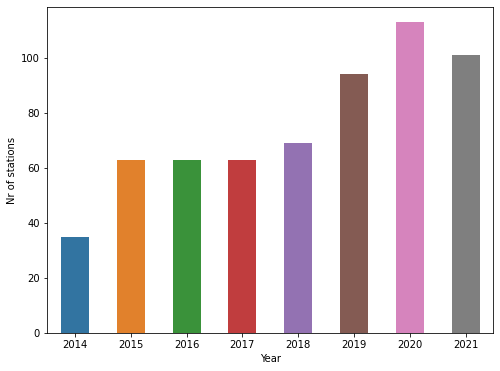

In [59]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=stations, x="Ano", y="Count")
# ax.set_yscale('log')
ax.set_xlabel('Year', fontsize=10)
ax.set_ylabel('Nr of stations', fontsize=10)
change_width(ax, .5)
plt.show()

This annual growth is normal since nowadays we believe that people are aware of a more sustainable and ecological world. We think because of the pandemic we are facing from the year 2020 till now, there is a decrease in stations in 2021 as there are more people in remote work and some of us feel insecure about using a bike that is used by multiple people. However, this difference is minimal, as we will see below.

In [60]:
year_ID = bikes.groupby(['Ano', 'Id_Aparcamiento_Origen']).size().reset_index(name='Count')
# year_ID.head(30)

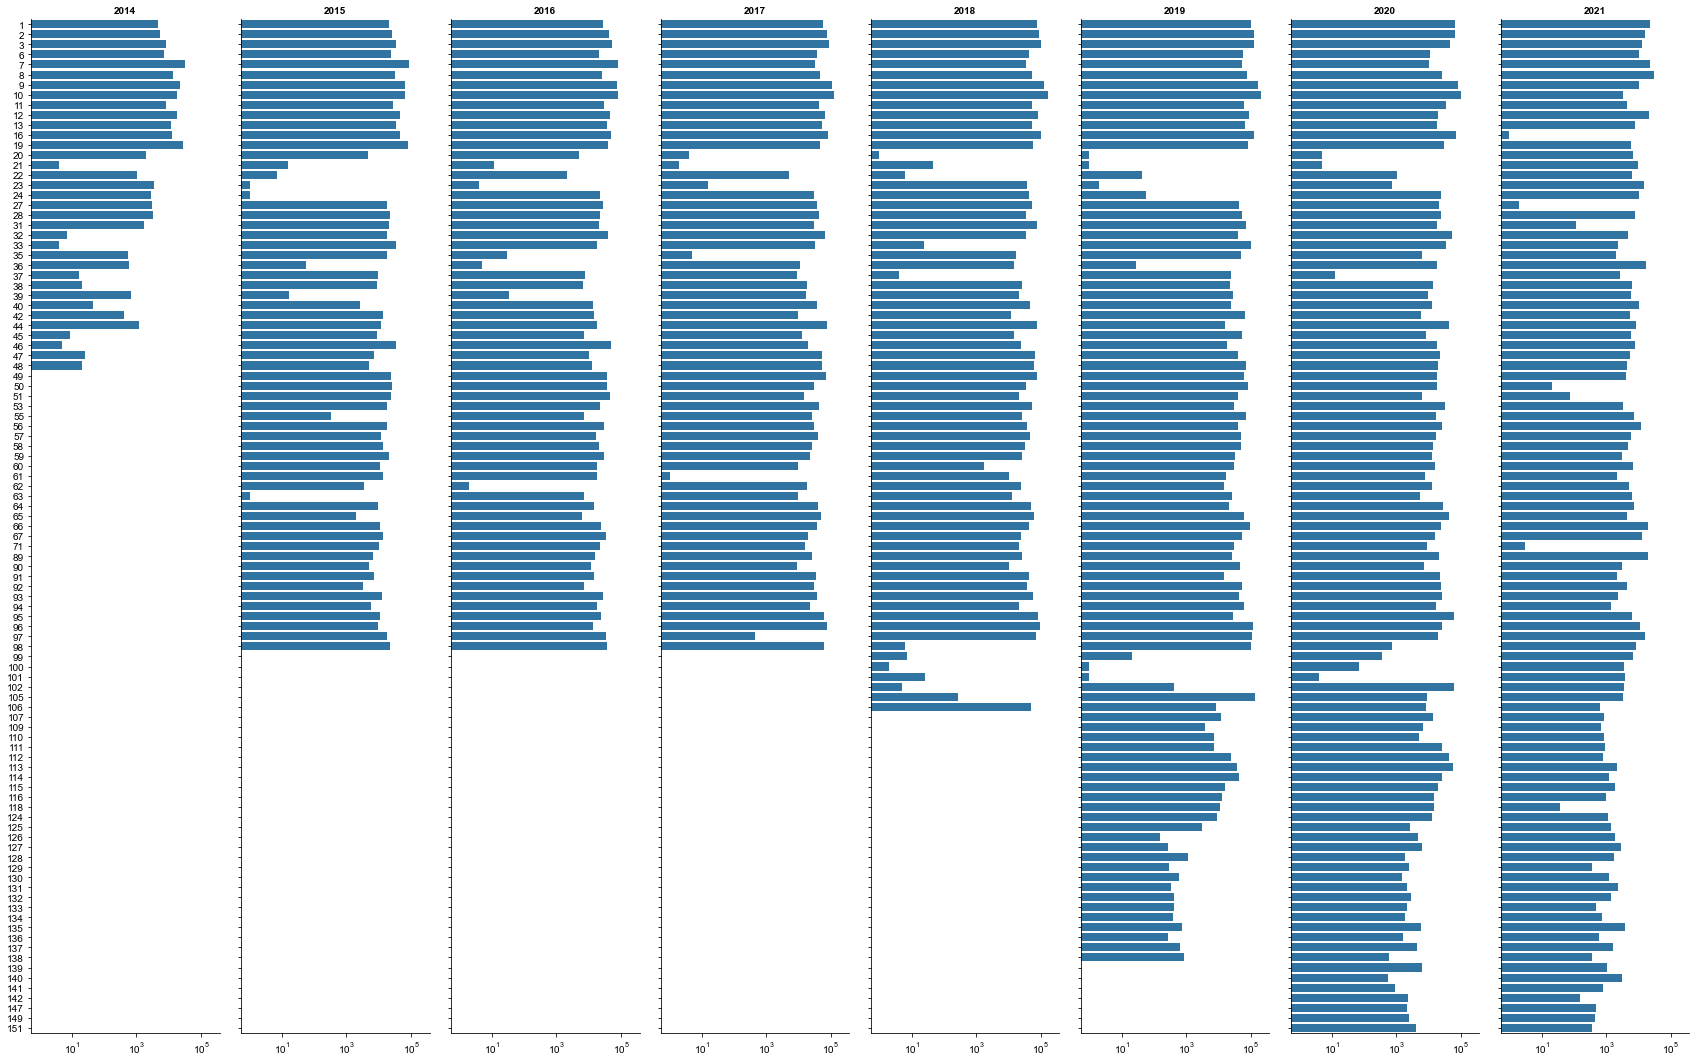

In [61]:
g = sns.FacetGrid(year_ID, col="Ano", height=15, aspect=0.2)
g.map_dataframe(sns.barplot, 'Count','Id_Aparcamiento_Origen', orient='h')
g.set(xscale="log")
# g.set_yticklabels(np.arange(min(year_ID.Id_Aparcamiento_Origen), max(year_ID.Id_Aparcamiento_Origen), 2))
g.set_titles(col_template="{col_name}", fontweight='bold')
g.set_axis_labels('', '') 
sns.set(font_scale = 1)
plt.show()

The above plot shows the number of bikes requested for each station by year.
As we can see, there are stations that are rarely used in this period. 
 
Therefore, we excluded stations with demand of one bike per hour.

Also, we will only consider the period between 2018 and 2021 because it is in this period that we have the weather information.

In [62]:
bikes = bikes[bikes.Rented > 1]

In [63]:
bikes = bikes[bikes.Ano > 2017]

In [64]:
bikes.shape

(8895058, 43)

#### Let's analyse 2020

In [65]:
d2020 = bikes[bikes['Ano'] == 2020]

In [66]:
d2020.shape

(1837174, 43)

General behaviour during d2020

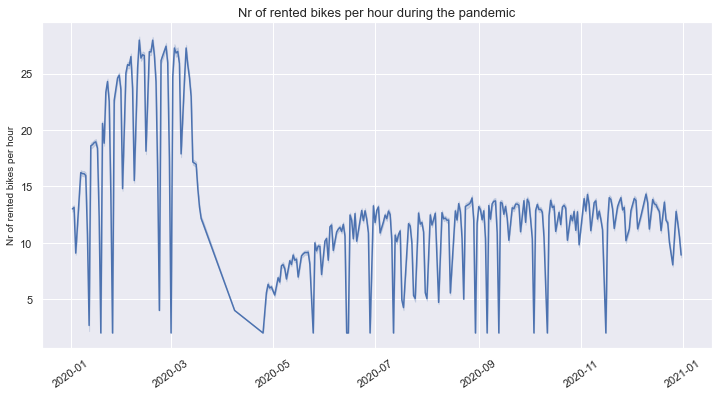

In [67]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=d2020, x="Fecha_Prestamo_data", y="Rented")
ax.set_xlabel('', )
ax.set_ylabel('Nr of rented bikes per hour', fontsize=10)
ax.set_title('Nr of rented bikes per hour during the pandemic', fontsize=13)
plt.xticks(rotation=35)
plt.show()

There is a clear change of traffic from March to May which is justified by the pandemic.

Also, we notice some lower peaks, which seems to be the weekends as we can see below.

Let's look at the behaviour before the pandemic.

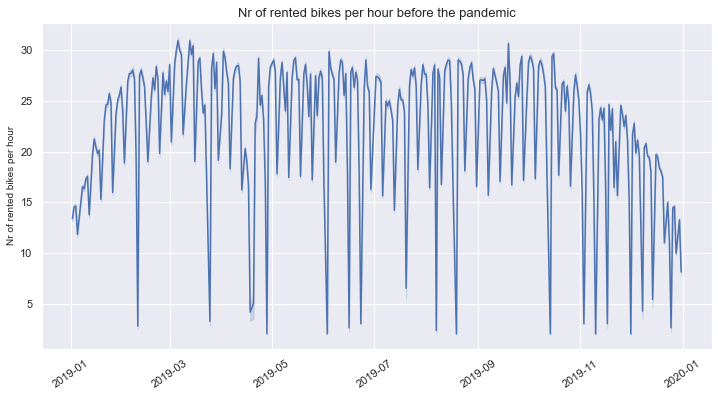

In [68]:
d2019 = bikes[bikes['Ano'] == 2019]
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=d2019, x="Fecha_Prestamo_data", y="Rented")
ax.set_xlabel('', )
ax.set_ylabel('Nr of rented bikes per hour', fontsize=10)
ax.set_title('Nr of rented bikes per hour before the pandemic', fontsize=13)
plt.xticks(rotation=35)
plt.show()

There has been a drop in rented bikes since November, but from January onwards there is an increase in demand again.

Which day of the week do people use bikes the most?

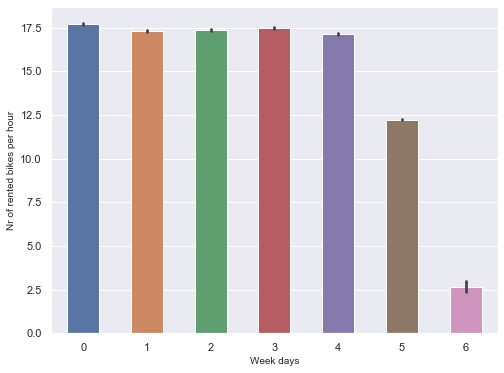

In [69]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=d2020, x="Dias_Semana", y="Rented")
# ax.set_yscale('log')
ax.set_xlabel('Week days', fontsize=10)
ax.set_ylabel('Nr of rented bikes per hour', fontsize=10)
change_width(ax, .5)
plt.show()

0 - Monday
6 - Sunday

Bike rentals are practically consistent throughout the working days. However, at the weekend there are a service outage, especially on Sundays.

What time of day there is more traffic?

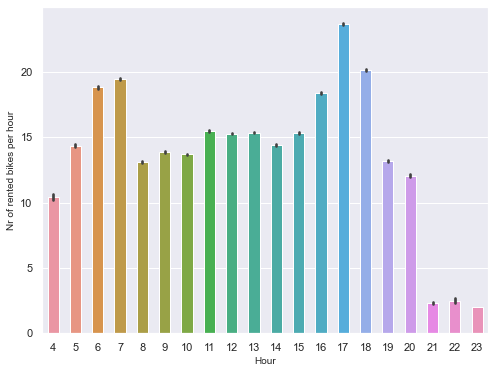

In [70]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=d2020, x="Hora_Origen", y="Rented")
# ax.set_yscale('log')
ax.set_xlabel('Hour', fontsize=10)
ax.set_ylabel('Nr of rented bikes per hour', fontsize=10)
change_width(ax, .5)
plt.show()

The image shows that there is more demand for bicycles at the beginning of the day and in the late afternoon, which means that people use this service as a means of transport to work or school.

Is there a connection between temperature and demand for bicycles?

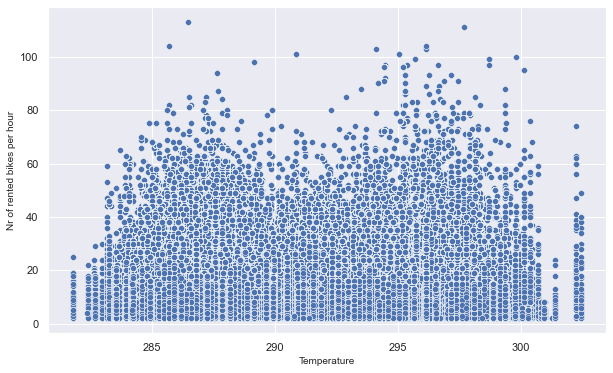

In [71]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=d2020, x="temp", y="Rented")
# ax.set_yscale('log')
ax.set_xlabel('Temperature', fontsize=10)
ax.set_ylabel('Nr of rented bikes per hour', fontsize=10)
change_width(ax, .5)
plt.show()

It would be expected that people tend to use bicycles more when the temperature is higher, however what we observe in the case of Medellin is that there is no obvious connection between temperature and demand.

Which station is most popular?

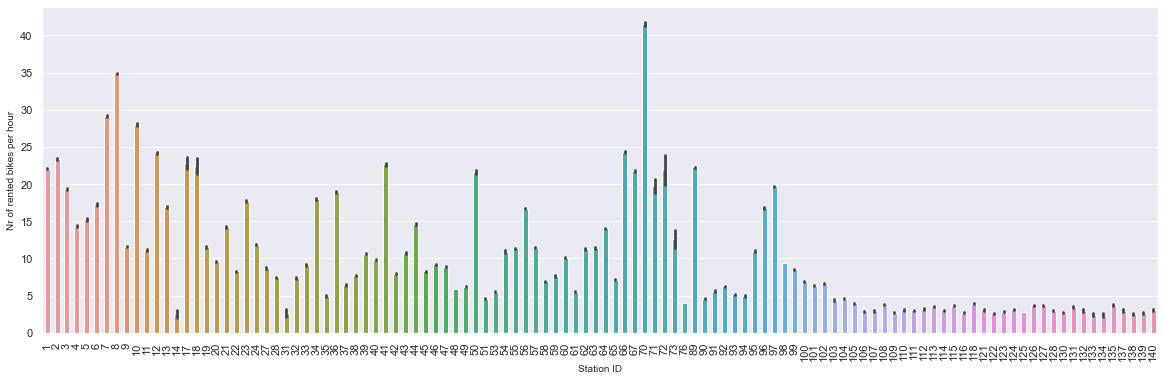

In [72]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(data=d2020, x="Id_Aparcamiento_Origen", y="Rented")
# ax.set_yscale('log')
ax.set_xlabel('Station ID', fontsize=10)
ax.set_ylabel('Nr of rented bikes per hour', fontsize=10)
change_width(ax, .5)
plt.xticks(rotation=90)
plt.show()

Let's look at station 70

In [73]:
station70 = d2020[d2020.Id_Aparcamiento_Origen == 70]
station70 = station70[['Fecha_Prestamo_data','Hora_Origen','Hora_Destino', 'Dias_Semana', 'Rented', 'Returned']]

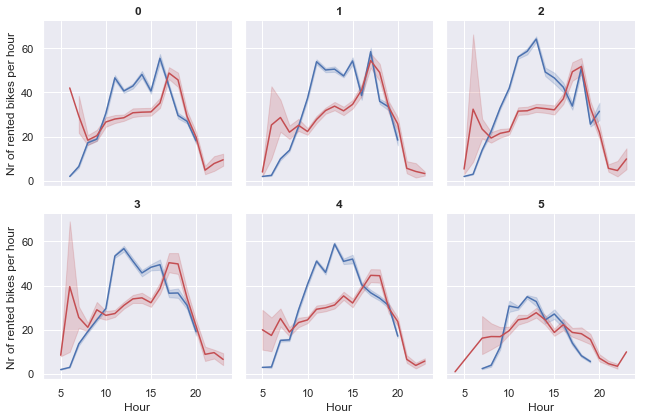

In [74]:
g = sns.FacetGrid(station70, col="Dias_Semana", col_wrap=3)
g.map_dataframe(sns.lineplot, 'Hora_Origen','Rented', color='b', legend=True)
g.map_dataframe(sns.lineplot, 'Hora_Destino','Returned', color='r')
g.add_legend()
# g.set_yticklabels(np.arange(min(year_ID.Id_Aparcamiento_Origen), max(year_ID.Id_Aparcamiento_Origen), 2))
g.set_titles(col_template="{col_name}", fontweight='bold')
g.set_axis_labels('Hour', 'Nr of rented bikes per hour') 
sns.set(font_scale = 1)
plt.show()

Blue - Nr of rented bikes per hour in origin 

Red - Nr of returned bikes per hour in destination

### Cluster

We follow the methodology applied in [this]( https://ieeexplore.ieee.org/document/9375958) article where the objective is to group stations based on demand.

In [121]:
station_hours = bikes[['Id_Aparcamiento_Origen', 'Fecha_Prestamo_data', 'Horas_grp', 'Rented']]
station_hours.head()

,Id_Aparcamiento_Origen,Fecha_Prestamo_data,Horas_grp,Rented
147180,36,2018-09-25,12-17pm,18
147204,3,2018-09-25,12-17pm,41
147251,37,2018-09-25,12-17pm,8
165247,2,2018-09-25,12-17pm,30
202201,44,2018-09-25,12-17pm,14


In [122]:
bikes.Horas_grp.unique()

array(['12-17pm', '5-11am', '0-5am', '18-23pm'], dtype=object)

In [123]:
station_hours['Rented'] = station_hours.groupby(['Id_Aparcamiento_Origen', 'Horas_grp'])['Rented'].transform(sum)

<ipython-input-123-48e829dbd05a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_hours['Rented'] = station_hours.groupby(['Id_Aparcamiento_Origen', 'Horas_grp'])['Rented'].transform(sum)


In [124]:
station_hours = station_hours.drop_duplicates(subset=['Id_Aparcamiento_Origen', 'Horas_grp', 'Rented'])

In [125]:
station_hours.shape

(472, 4)

In [126]:
# Normalise the demand 
scaler = MinMaxScaler()
station_hours.Rented = scaler.fit_transform(station_hours[['Rented']])

In [127]:
station_hours = station_hours.pivot_table(index ='Id_Aparcamiento_Origen', columns ='Horas_grp', values =['Rented'], fill_value=0)

In [128]:
station_hours.head()

Rented                              
Horas_grp                  0-5am   12-17pm   18-23pm    5-11am
Id_Aparcamiento_Origen                                        
1                       0.043690  0.215464  0.024621  0.417157
2                       0.013123  0.402727  0.176123  0.279106
3                       0.010891  0.464104  0.124755  0.294980
4                       0.000401  0.105964  0.025282  0.060578
5                       0.001078  0.101900  0.022750  0.047882

In [129]:
X = station_hours.to_numpy()

In [130]:
kmeans = KMeans(n_clusters=15, random_state=0).fit(X)

In [131]:
station_hours['cluster'] = kmeans.labels_

In [132]:
station_hours.head()

Rented                               cluster
Horas_grp                  0-5am   12-17pm   18-23pm    5-11am        
Id_Aparcamiento_Origen                                                
1                       0.043690  0.215464  0.024621  0.417157       8
2                       0.013123  0.402727  0.176123  0.279106       9
3                       0.010891  0.464104  0.124755  0.294980       9
4                       0.000401  0.105964  0.025282  0.060578      11
5                       0.001078  0.101900  0.022750  0.047882      11

In [133]:
def increase_priority(num):
    station_dict = {
        0:14,
        1:13,
        2:12,
        3:11,
        4:10,
        5:9,
        6:8,
        7:7,
        8:6,
        9:5,
        10:4,
        11:3, 
        12:2,
        13:1,
        14:0
    }
    return station_dict.get(num)

In [134]:
station_hours['cluster'] = station_hours['cluster'].apply(increase_priority)

In [135]:
group_length = [0] * 15
for val in enumerate(station_hours['cluster']):
    group_length[val[1]] = group_length[val[1]] + 1
print(group_length)
group_length_dict = {}
for i, val in enumerate(group_length):
    group_length_dict.update({i:val})
print(group_length_dict)

[2, 1, 2, 12, 21, 2, 2, 1, 1, 9, 1, 3, 1, 2, 64]
{0: 2, 1: 1, 2: 2, 3: 12, 4: 21, 5: 2, 6: 2, 7: 1, 8: 1, 9: 9, 10: 1, 11: 3, 12: 1, 13: 2, 14: 64}


In [136]:
cluster = []
for index, row in station_hours.iterrows():
    dicts = {"station_id" : index, "cluster" : row['cluster'][0]}
    cluster.append(dicts)

In [137]:
bikes_cp = bikes.copy()

In [138]:
def group_stations(num):
    for i in range(0, len(cluster)):
        if cluster[i]['station_id'] == num:
            return cluster[i]['cluster']

In [139]:
bikes_cp['Station_cluster'] = bikes_cp['Id_Aparcamiento_Origen'].apply(group_stations)

In [140]:
bikes_cp.head()

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Importe,...,pressure,humidity,temp_min,temp_max,speed,deg,clouds,date,hour,Station_cluster
147180,9805051,117812,000017AFE954,2018-09-25 15:52:05,2018-09-25 16:54:29,36,16,36.0,4.0,0.0,...,1019,54,294.15,298.15,3.6,10,75,2018-09-25,15.0,2.0
147204,9805769,27151,000017AFDA51,2018-09-25 16:36:23,2018-09-25 16:55:45,3,17,36.0,18.0,0.0,...,1019,48,295.15,300.15,3.6,340,75,2018-09-25,16.0,5.0
147251,9806079,114788,000017AFD206,2018-09-25 16:51:56,2018-09-25 16:59:12,37,19,89.0,3.0,0.0,...,1019,48,295.15,300.15,3.6,340,75,2018-09-25,16.0,4.0
165247,9805680,104857,000017AFDD8B,2018-09-25 16:31:04,2018-09-25 16:59:27,2,1,9.0,8.0,0.0,...,1019,48,295.15,300.15,3.6,340,75,2018-09-25,16.0,5.0
202201,9805973,34974,000017AFF2F7,2018-09-25 16:46:00,2018-09-25 16:54:43,44,1,21.0,1.0,0.0,...,1019,48,295.15,300.15,3.6,340,75,2018-09-25,16.0,9.0


In [141]:
# hourly average trips for given station (seasons - 3 months each, day of week - 4 weeks in a month(30/7), 4 years data(2018,2019,2020,2021), size of groups) 
def average_trips(num, group_id):
    return (int) (math.ceil(num / ((3 * 4 * 4) * group_length_dict.get(group_id))))

In [142]:
bikes_cp['Rented_cls'] = np.vectorize(average_trips)(bikes_cp['Rented'], bikes_cp['Station_cluster'])

In [143]:
bikes_cp.Rented_cls.describe()

count    8.895058e+06
mean     1.045672e+00
std      2.133898e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      3.000000e+00
Name: Rented_cls, dtype: float64

In [144]:
bikes_cp.Rented_cls.unique()

array([1, 2, 3])

#### Correlation

In [148]:
cols = bikes_cp.columns[np.r_[5:9,16:28, 32:41, 43, 44]]
cols

Index(['Id_Aparcamiento_Origen', 'Posicion_Origen', 'Id_Aparcamiento_Destino',
       'Posicion_Destino', 'Duracion_dias', 'Duracion_horas', 'Ano', 'Mes',
       'Dia', 'Dias_Semana', 'Dias_habiles', 'Hora_Origen', 'Hora_Destino',
       'Estaciones', 'Vacaciones', 'Ocupacion', 'temp', 'feels_like',
       'pressure', 'humidity', 'temp_min', 'temp_max', 'speed', 'deg',
       'clouds', 'Station_cluster', 'Rented_cls'],
      dtype='object')

In [149]:
bikes_cp = bikes_cp[cols]
corr = bikes_cp.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Duracion_dias,Duracion_horas,Ano,Mes,Dia,Dias_Semana,Dias_habiles,Hora_Origen,Hora_Destino,Estaciones,Vacaciones,Ocupacion,Station_cluster,Rented_cls
Id_Aparcamiento_Origen,1.00,0.24,0.19,0.08,-0.00,0.01,0.16,0.03,0.00,0.00,0.00,0.07,0.07,0.00,0.00,0.33,0.10,-0.11
Posicion_Origen,0.24,1.00,0.26,0.38,-0.00,-0.01,0.04,0.02,0.00,-0.00,-0.00,0.01,0.01,0.01,0.00,0.56,-0.11,-0.11
Id_Aparcamiento_Destino,0.19,0.26,1.00,0.27,-0.00,0.01,0.16,0.02,0.00,0.01,-0.00,-0.09,-0.09,-0.00,0.00,0.33,0.07,-0.05
Posicion_Destino,0.08,0.38,0.27,1.00,0.00,-0.00,0.02,0.01,0.00,-0.00,-0.00,-0.03,-0.03,0.01,0.00,0.56,0.01,-0.02
Duracion_dias,-0.00,-0.00,-0.00,0.00,1.00,0.97,-0.00,-0.00,0.00,0.01,-0.38,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00
Duracion_horas,0.01,-0.01,0.01,-0.00,0.97,1.00,0.04,-0.00,-0.00,0.01,-0.37,0.01,0.02,-0.01,0.00,-0.05,0.01,-0.01
Ano,0.16,0.04,0.16,0.02,-0.00,0.04,1.00,-0.22,-0.01,0.00,-0.00,0.01,0.02,-0.20,0.00,0.01,0.09,-0.04
Mes,0.03,0.02,0.02,0.01,-0.00,-0.00,-0.22,1.00,-0.03,0.02,0.00,0.01,0.01,0.68,0.00,0.04,0.01,-0.02
Dia,0.00,0.00,0.00,0.00,0.00,-0.00,-0.01,-0.03,1.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00
Dias_Semana,0.00,-0.00,0.01,-0.00,0.01,0.01,0.00,0.02,-0.00,1.00,-0.01,-0.04,-0.04,0.03,-0.00,-0.01,0.00,-0.03


In [150]:
bikes_cp.shape

(8895058, 27)

In [151]:
# create correlation matrix
corr_matrix = bikes_cp.corr().abs()

# upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# drop features 
bikes_cp.drop(to_drop, axis=1, inplace=True)

<ipython-input-151-5cc7278d3d96>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [152]:
bikes_cp.shape

(8895058, 25)

In [165]:
bikes_cp.isna().sum()

Id_Aparcamiento_Origen           0
Posicion_Origen                  0
Id_Aparcamiento_Destino       1986
Posicion_Destino             57574
Duracion_dias                    0
Ano                              0
Mes                              0
Dia                              0
Dias_Semana                      0
Dias_habiles                     0
Hora_Origen                      0
Estaciones                       0
Vacaciones                       0
Ocupacion                  8074149
temp                           112
feels_like                     112
pressure                       112
humidity                       112
temp_min                       112
temp_max                       112
speed                          112
deg                            112
clouds                         112
Station_cluster                  0
Rented_cls                       0
dtype: int64

In [170]:
cols = bikes_cp.columns[np.r_[0,4:13,14:25]]
cols

Index(['Id_Aparcamiento_Origen', 'Duracion_dias', 'Ano', 'Mes', 'Dia',
       'Dias_Semana', 'Dias_habiles', 'Hora_Origen', 'Estaciones',
       'Vacaciones', 'temp', 'feels_like', 'pressure', 'humidity', 'temp_min',
       'temp_max', 'speed', 'deg', 'clouds', 'Station_cluster', 'Rented_cls'],
      dtype='object')

In [171]:
bikes_cp = bikes_cp[cols]

In [174]:
bikes_cp = bikes_cp.apply(lambda x: x.fillna(x.mean()),axis=0)

### Modeling

In [184]:
def prepare_modeling(df):
    data_mod_values = df.values
    X, y = data_mod_values[:, :-1], data_mod_values[:, -1]
    y = LabelEncoder().fit_transform(y)
    return X, y

In [186]:
df, y = prepare_modeling(bikes_cp)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [ ]:
params = {'n_estimators': 750, 'max_depth': 30, 'min_samples_split': 15,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

model = clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

In [ ]:
y_pred = clf.staged_predict(X_test)

In [ ]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

In [ ]:
X_grid = np.arange(X_test[:,7].min(), X_test[:,7].max(), 0.25)
X_grid = X_grid.reshape((len(X_grid), 1)) 
plt.scatter(X_grid, y_test[:92])
plt.plot(X_grid, y_pred[:92])
plt.xlabel('Hour')
plt.ylabel('Nr of rented bikes')
plt.ylim(0,6)

## Conclusions

For this challenge we have done extensive research, and we note that there are many researchers trying to solve this problem. And so, we chose not to include in this study the baseline results, i.e. performance of a machine learning model with the original data, since some of the baseline results are already described in some of the papers, and so we could save some time to investigate more solutions. For instance, metheorogical data is very important to improve the results as we notice in this [research paper](https://arxiv.org/pdf/2105.01125.pdf).

Unfortunately we were not able to get the forecast results in time.

### Scalability and Impact
We think our work is well structured and therefore scalable. However, to have a positive impact we think it should be tested with other machine learning algorithms as well as different clusters.


### Future Work

A quality service in bike sharing is very important nowadays so that there is more adhesion and consequently a decrease in the use of cars and pollution. And for this, real-time demand forecasting is fundamental.: https://ieeexplore.ieee.org/document/9375958

As future work, it would also be essential to have other attributes such as distance between stations, station capacity and other factors that may impact demand.

Beside that, the determination of total score for bike station attractiveness could be a great plus. (Paper: https://www.mdpi.com/2071-1050/12/21/9062)

Regarding thepredictive task, it is necessary to repeat the experiment using a grid search for hyperparameterisation. It is also important to experiment with other machine learning algorithms as we have already mentioned. 